In [ ]:
# import's

import csv
import numpy as np
from numpy import unravel_index
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.lines import Line2D

# Funkcijos

## Duomenims

In [ ]:
# irisų duomenims
# apibrėžta funkcija, kuri perskaito duomenis iš failo, perrašo reikiamus duomenis į csv failą
# (nes lenviau atskirti stulpelius), tada skaito csv failą po eilutę
# funkcija grazina atskirai duomenis ir klases

def read_and_change_data_iris(inputFile, outputFile):
  with open(inputFile, 'r') as fileInput:
    with open(outputFile, 'w') as fileOutput:
      for row in fileInput:
          modifiedString = row.replace('Iris-setosa', '0').replace('Iris-versicolor','1').replace('Iris-virginica', '2')
          fileOutput.write(modifiedString)

  inputData = []
  inputLabel = []

  with open(outputFile) as fileInput:
    reader = csv.reader(fileInput, delimiter=',')
    for row in reader:
      if row == []:
        break
      inputData.append([float(row[0]), float(row[1]), float(row[2]), float(row[3])])
      inputLabel.append(float(row[4]))

  return inputData, inputLabel

In [ ]:
# funkcija, kuri atsitiktinai sumaišo duomenis

def shuffle_data(inputData, inputLabel):
  return shuffle(inputData, inputLabel)

In [ ]:
# funkcija, kuri normalizuoja (stardantizuoja duomenis), kad jie būtų tarp 0 ir 1

def normalize_data(data):
  return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

## SOM

In [ ]:
# funkcija kuri sugeneruoja pradinius svorius
# seed naudojamas, kad sugeneruotu vis tuos pačius svorius ir visi bandymai turėtų vienodus svorius

def generate_weights(numRows, numCols, features):
  np.random.seed(12)
  weights = np.random.random_sample(size=(numRows, numCols, features))

  return weights

In [ ]:
# funkcija, kuri suskaičiuoja euklidinį atstumą tarp vektorių

def euclidean_distance(neuronWeights, dataRow):
  return np.sqrt(np.sum(np.power(np.array(neuronWeights)-np.array(dataRow), 2)))

In [ ]:
# funkcija, kuri suskaičiuoja manhateno atstumą tarp vektorių

def manhatten_distance(neuronWinPlace, neuronNeighbourPlace):
  return np.sum(np.abs(np.array(neuronWinPlace)-np.array(neuronNeighbourPlace)))

In [ ]:
class SOM:

  # sukuriamas som modelis su random sugeneruotais svoriais
  # modeliui reikia pateikti som dydį bei duomenų požymių skaičių
  def __init__(self, num_rows, num_cols, features):
    self.rows = num_rows
    self.cols = num_cols
    self.features = features
    self.weights = generate_weights(self.rows, self.cols, features)


  # funkcija, kuri randa neuroną nugalėtoją duomenų įrašui
  def winner(self, data_row):
    euclidean_distances = np.empty(shape=(self.rows, self.cols))
    for row in range(self.rows):
      for col in range(self.cols):
        euclidean_distances[row][col] = euclidean_distance(self.weights[row][col], data_row)

    winner = np.array(unravel_index(np.argmin(euclidean_distances), euclidean_distances.shape))
    return winner


  # treniravimo funkcija, apmoko som modelį pagal nustatytą epochų skaičių
  # paduodami duomenys, mokymosi parametras, manhatteno atstumas kaimyninių neuronų svorių keitimui
  def train(self, data, epoch_count, max_learning, max_range):
    self.epochs = epoch_count
    self.max_learning = max_learning
    self.max_range = max_range

    # einame per visas mokymosi epochas, kiekvienai epochai skaičiuojamas mokymosi parametras priklausomai nuo einamos epochos
    # kaimyninis atstumas skaičiuojamas priklausomai nuo iteracijų skačiaus: apskaičiuojamas mokymosi parametro koeficientas,
    # kuris sudauginamas su pirminiu manhatteno atstumu
    # mokymosi parametras skaičiuojamas sudauginus gautą mokymosi parametro koeficientą su nustatytu pirminiu mokymosi parametru
    for iter in range(self.epochs):
      learning_par = 1 - (np.float64(iter)/self.epochs)
      current_learning = learning_par * self.max_learning
      current_range = learning_par * self.max_range

      # einame per visus duomenų įrašus ir renkame įrašui neuroną nugalėtoją
      for data_row in data:
        winner = self.winner(data_row)

        # keičiami svorius prilausomai pagal neurono nugalėtojo koordinates
        # kaiminystės funkcija - burbuliuko,
        # priklausomai nuo atstumo nuo neurono nugalėtojo kiti neuoronai priskiriami arba nepriskiriami kaimynams
        # kaimynų svoriai koreguojami
        for row in range(self.rows):
          for col in range(self.cols):
            if manhatten_distance(winner, [row, col]) < current_range:
                self.weights[row][col] = self.weights[row][col] + current_learning * (data_row - self.weights[row][col])


  # som testavimas, paduodami duomenis yra sudedami į som žemėlapį
  # kiekvienam duomenų įrašui randamas neuronas nugalėtojas ir pagal jo koordinates
  # rezultatų žemėlapyje išsaugoma įrašo klasė
  # apskaičiuojama kvantavimo paklaida
  def test(self, data, output):
    map = np.empty(shape=(self.rows, self.cols), dtype=object)
    quantization_error = 0

    for row in range(self.rows):
      for col in range(self.cols):
        map[row][col] = []

    for row in range(data.shape[0]):
      winner = self.winner(data[row])
      map[winner[0]][winner[1]].append(output[row])
      quantization_error = quantization_error + euclidean_distance(data[row], self.weights[winner[0]][winner[1]])

    return map, quantization_error/data.shape[0]

In [ ]:
# funkcija, kuri atspausdina gautą som rezultatų žemėlapi
# skirtingos spalvos reiškia skirtingas klases
# skirtingi skritulių dydžiai reiškia kiekį, kiek daug ar kiek mažai tos klasės duomenų įrašų buvo priskirta
# atspausdinama ir legenda, paaiškinanti kuri spalva kuriai klasei priskiriama

def print_map(map, row_nr, col_nr):
  colors = ['r','g','b']
  plt.figure(figsize=(5,5))
  plt.ylim(0.0, row_nr)
  plt.xlim(0.0, col_nr)
  plt.xticks(range(0, row_nr+1, 1))
  plt.yticks(range(0, col_nr+1, 1))
  plt.grid(linestyle='--', color='gray', linewidth=0.5)
  labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

  for row in range(row_nr):
    for col in range(col_nr):
      if map[row][col] != []:
        pasikartojimai = Counter(map[row][col])
        dominuojantis_elementas = pasikartojimai.most_common(1)
        label = int(pasikartojimai.most_common(1)[0][0])
        label_count = pasikartojimai.most_common(1)[0][1]
        plt.plot(row+0.5, col+0.5, 'o', markersize=5+label_count*2, markerfacecolor=colors[label], markeredgecolor='k')

  legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(colors, labels)]
  plt.legend(handles=legend_elements, title='Klasės:',  bbox_to_anchor=(1, 1), loc='upper left')

# SOM veikimas su irisų duomenimis

In [ ]:
# pasiruošiami irisų duomenys

input_file_iris = 'iris.data'
output_file_iris = 'iris.csv'

input_data_iris, input_label_iris = read_and_change_data_iris(input_file_iris, output_file_iris)
input_data_iris = normalize_data(input_data_iris)
input_data_iris, input_label_iris = shuffle_data(input_data_iris, input_label_iris)

Kvantavimo paklaidos reikšmė:  0.08808874019412927


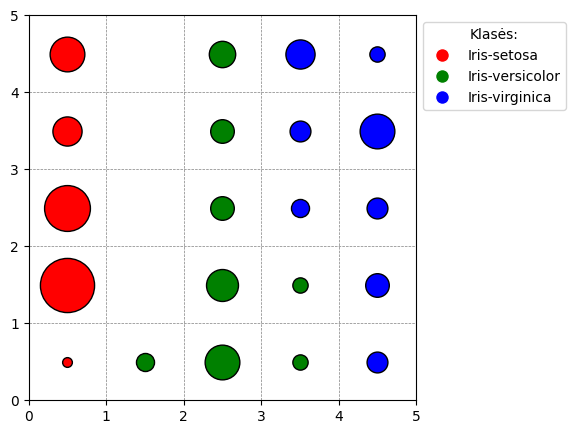

In [ ]:
# sukuriamas som 5x5, apmokomos pagal nustatytą epochų skaičių ir mokymosi greitį
# apmokytas som yra ištestuojamas, jo rezultatai atspausdinami

epochs = 500
learning_rate = 0.5
manhatten_dist = 4
som_rows = 5
som_cols = 5

som = SOM(som_rows, som_cols, input_data_iris.shape[1])
som.train(input_data_iris, epochs, learning_rate, manhatten_dist)
map, err = som.test(input_data_iris, input_label_iris)
print('Kvantavimo paklaidos reikšmė: ', err)
print_map(map, som_rows, som_cols)

Kvantavimo paklaidos reikšmė:  0.03394469133880321


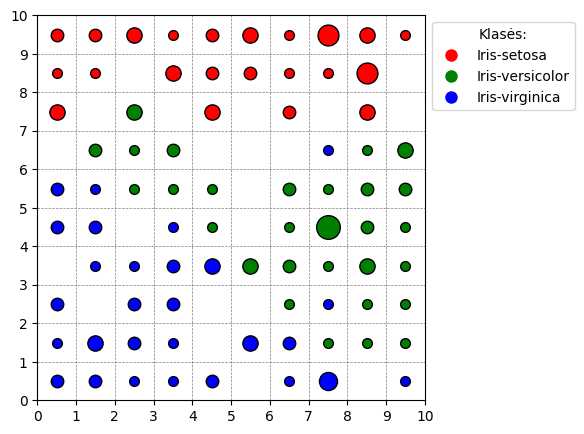

In [ ]:
# sukuriamas som 10x10, apmokomos pagal nustatytą epochų skaičių ir mokymosi greitį
# apmokytas som yra ištestuojamas, jo rezultatai atspausdinami

epochs = 500
learning_rate = 0.5
manhatten_dist = 4
som_rows = 10
som_cols = 10

som = SOM(som_rows, som_cols, input_data_iris.shape[1])
som.train(input_data_iris, epochs, learning_rate, manhatten_dist)
map, err = som.test(input_data_iris, input_label_iris)
print('Kvantavimo paklaidos reikšmė: ', err)
print_map(map, som_rows, som_cols)